In [1]:
import fastjet as fj
import pythia8
from recursivetools import pyrecursivetools as rt
from lundplane import pylundplane as lund
from pythiafjtools import pypythiafjtools as pyfj
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
from tqdm import tnrange, tqdm_notebook
import joblib
import os

In [4]:
def deltas(jets, jets0):
    for i in range(len(jets)):
        yield jets0[i].perp() - jets[i].perp()

def create_and_init_pythia(config_strings=[]):
    pythia = pythia8.Pythia()
    for s in config_strings:
        pythia.readString(s)
    for extra_s in ["Next:numberShowEvent = 0", "Next:numberShowInfo = 0", "Next:numberShowProcess = 0"]:
        pythia.readString(extra_s)
    if pythia.init():
        return pythia
    return None

sconfig_pythia = [ "Beams:eCM = 8000.", "HardQCD:all = on", "PhaseSpace:pTHatMin = 100."]
pythia = create_and_init_pythia(sconfig_pythia)

# set up our jet definition and a jet selector
jet_R0 = 0.4
jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R0)
jet_selector = fj.SelectorPtMin(100.0) & fj.SelectorPtMax(200.0) & fj.SelectorAbsEtaMax(1)
sd = rt.SoftDrop(0, 0.1, 1.0)

In [14]:
all_jets = []
for iEvent in tqdm_notebook(range(10000), 'event'):
    if not pythia.next(): continue
    parts = pyfj.vectorize(pythia, True, -1, 1, False)
    jets = jet_selector(jet_def(parts))
    all_jets.extend(jets)

In [15]:
jet_def_lund = fj.JetDefinition(fj.cambridge_algorithm, 1.0)
lund_gen = lund.LundGenerator(jet_def_lund)

In [16]:
%%time
lunds = [lund_gen.result(j) for j in all_jets]

CPU times: user 177 ms, sys: 24.6 ms, total: 202 ms
Wall time: 201 ms


In [17]:
%%time
log_kt = []
log_1oDelta = []
for l in lunds:
    for s in l:
        log_kt.append(math.log(s.kt()))
        log_1oDelta.append(math.log(1./s.Delta()))

CPU times: user 236 ms, sys: 5.35 ms, total: 242 ms
Wall time: 241 ms


(array([[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.71877698, 0.80726428, 0.89575159, 0.98423889, 1.0727262 ,
        1.1612135 , 1.2497008 , 1.33818811, 1.42667541, 1.51516272,
        1.60365002, 1.69213732, 1.78062463, 1.86911193, 1.95759924,
        2.04608654, 2.13457384, 2.22306115, 2.31154845, 2.40003576,
        2.48852306, 2.57701036, 2.66549767, 2.75398497, 2.84247228,
        2.93095958, 3.01944688, 3.10793419, 3.19642149, 3.2849088 ,
        3.3733961 , 3.4618834 , 3.55037071, 3.63885801, 3.72734532,
        3.81583262, 3.90431992, 3.99280723, 4.08129453, 4.16978183,
        4.25826914, 4.34675644, 4.43524375, 4.52373105, 4.61221835,
        4.70070566, 4.78919296, 4.87768027, 4.96616757, 5.05465487,
        5.14314218, 5.23162948, 5.32011679, 5.40860409, 5.49709139,
   

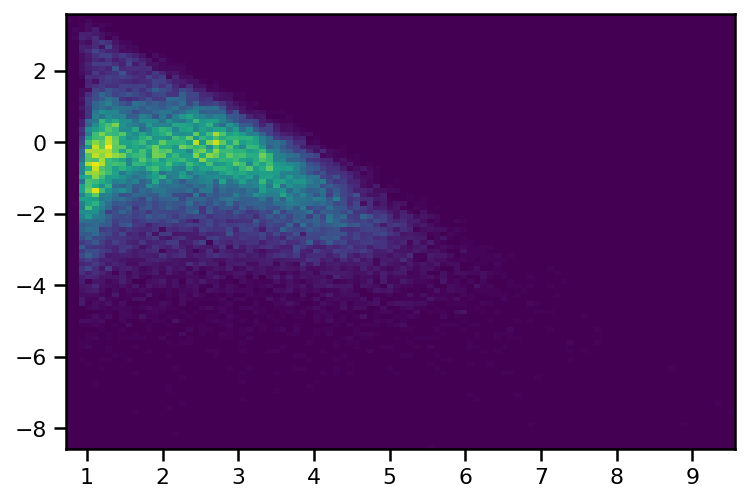

In [18]:
plt.hist2d(log_1oDelta, log_kt, bins=100)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 4., 2., 2.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.673456  , 0.75306704, 0.83267807, 0.91228911, 0.99190014,
        1.07151117, 1.15112221, 1.23073324, 1.31034428, 1.38995531,
        1.46956634, 1.54917738, 1.62878841, 1.70839945, 1.78801048,
        1.86762152, 1.94723255, 2.02684358, 2.10645462, 2.18606565,
        2.26567669, 2.34528772, 2.42489875, 2.50450979, 2.58412082,
        2.66373186, 2.74334289, 2.82295393, 2.90256496, 2.98217599,
        3.06178703, 3.14139806, 3.2210091 , 3.30062013, 3.38023116,
        3.4598422 , 3.53945323, 3.61906427, 3.6986753 , 3.77828634,
        3.85789737, 3.9375084 , 4.01711944, 4.09673047, 4.17634151,
        4.25595254, 4.33556358, 4.41517461, 4.49478564, 4.57439668,
        4.65400771, 4.73361875, 4.81322978, 4.89284081, 4.97245185,
   

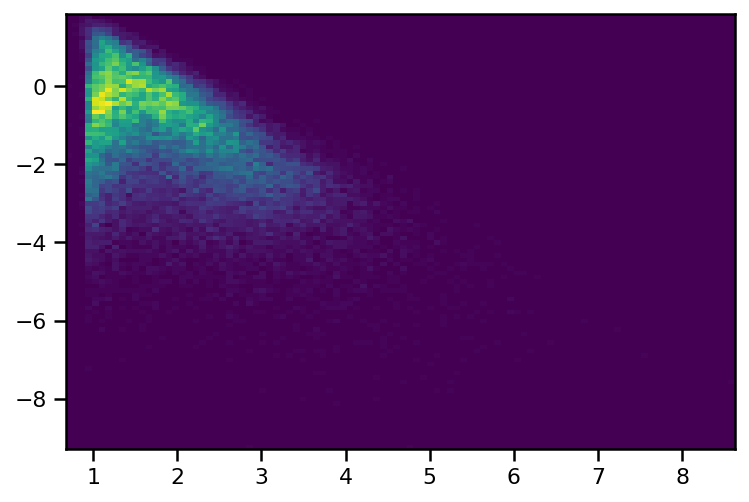

In [19]:
if not os.path.exists('test_lund_2d.joblib'):
    joblib.dump([log_1oDelta, log_kt], 'test_lund_2d.joblib') 
xy = joblib.load('test_lund_2d.joblib')
plt.hist2d(xy[0], xy[1], bins=100)